In [1]:
# Uncomment to run the notebook in Colab
# ! pip install -q "wax-ml[complete]@git+https://github.com/eserie/wax-ml.git"
# ! pip install -q --upgrade jax jaxlib==0.1.70+cuda111 -f https://storage.googleapis.com/jax-releases/jax_releases.html

In [2]:
# check available devices
import jax

In [3]:
print("jax backend {}".format(jax.lib.xla_bridge.get_backend().platform))
jax.devices()

jax backend cpu


[CpuDevice(id=0)]

# 🌡 Binning temperatures 🌡

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eserie/wax-ml/blob/main/docs/notebooks/03_ohlc_temperature.ipynb)

Let's again considering the air temperatures dataset.
It is sampled at an hourly resolution.
We will make "trailing" air temperature bins during each day and "reset" the bin
aggregation process at each day change.

In [4]:
import numpy as onp
import xarray as xr

In [5]:
from wax.accessors import register_wax_accessors
from wax.modules import OHLC, HasChanged

register_wax_accessors()

In [6]:
dataset = xr.tutorial.open_dataset("air_temperature")
dataset["date"] = dataset.time.dt.date.astype(onp.datetime64)

In [7]:
dataset

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53, time: 2920)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 ...
    date     (time) datetime64[ns] 2013-01-01 2013-01-01 ... 2014-12-31
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [8]:
def bin_temperature(da):
    day_change = HasChanged()(da["date"])
    return OHLC()(da["air"], reset_on=day_change)


output, state = dataset.wax.stream().apply(
    bin_temperature, format_dims=onp.array(dataset.air.dims)
)
output = xr.Dataset(output._asdict())

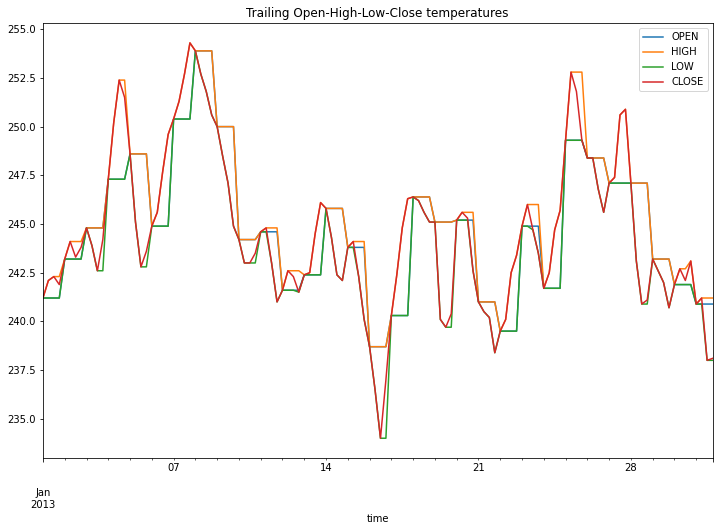

In [9]:
df = output.isel(lat=0, lon=0).drop(["lat", "lon"]).to_pandas().loc["2013-01"]
_ = df.plot(figsize=(12, 8), title="Trailing Open-High-Low-Close temperatures")

## The `UpdateOnEvent` module

The `OHLC` module uses the primitive `wax.modules.UpdateOnEvent`.

Its implementation required to complete Haiku with a central function
`set_params_or_state_dict` which we have actually integrated in this WAX-ML module.

We have opened an [issue on the Haiku github](https://github.com/deepmind/dm-haiku/issues/126)
to integrate it in Haiku.